# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as si
from scipy import stats
import sympy as sy
import csv
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import display
pd.options.display.max_columns = None

df = pd.read_csv('human_body_temperature.csv')

In [2]:
df.columns

Index(['temperature', 'gender', 'heart_rate'], dtype='object')

Question 1: Is the distribution of body temperatures normal?

The CDF from the body temp data matches very closely with the normal distribution with same mean and std. Therefore, I feel comfortable assuming a normal disribution.

(array([ 2.,  3.,  5.,  9.,  9., 23., 18., 22., 20., 11.,  5.,  0.,  2.,
         0.,  1.]),
 array([ 96.3,  96.6,  96.9,  97.2,  97.5,  97.8,  98.1,  98.4,  98.7,
         99. ,  99.3,  99.6,  99.9, 100.2, 100.5, 100.8]),
 <a list of 15 Patch objects>)

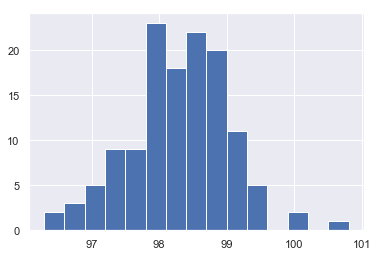

In [3]:
sns.set()
plt.hist(df['temperature'],bins=15)

In [2]:
#Calculate mean and st dev of body temp
temp_mean = np.mean(df['temperature'])
temp_std = np.std(df['temperature'])
#Generate samples from a normal distribution with same mean and std as body temp data
sim_temp_norm = np.random.normal(temp_mean,temp_std,100000)

In [3]:
#Create Function to calculate the Empirical Cumulative Distribution Function
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements.""" 
    # Number of data points: n    
    n = len(data)   
    # x-data for the ECDF: x    
    x = np.sort(data)    
    # y-data for the ECDF: y   
    y = np.arange(1, n+1) / n   
    return x, y

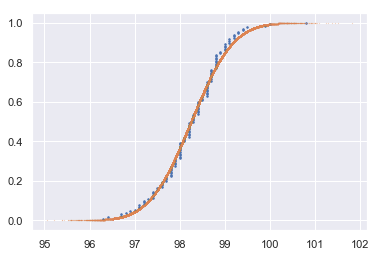

In [6]:
#Create Empirical CDF of body temp and simulated normal dist body temps
x,y = ecdf(df['temperature'])
x_sim,y_sim = ecdf(sim_temp_norm)
#Plot CDF's together to check if normal dist is a good fit
sns.set()
plt.plot(x,y, marker='.', linestyle='none',markersize=3)
plt.plot(x_sim,y_sim, marker='.', linestyle='none',markersize=.25)
plt.show()
#The CDF from the body temp data matches very closely with the 
#normal distribution with same mean and std

Question 2: Is the sample size large? Are the observations independent? 

The sample size is >30, and therefore meets the criteria for the CLT.
No information was given about how the sample was taken so I have no way of determining if the observations are independent.
If this is a random sample, independence of the observations is safe to assume. 

Question 3: Is the true population mean really 98.6 degrees F? First, try a bootstrap hypothesis test.

H_o = Average body temperature is equal to 98.6 degrees F.
H_a = Average body temperature is not equal to 98.6 degrees F.
Assuming the null hypothesis is true, we can take the observed difference (mean(data)-98.6) and compare it to boostrap samples of mean differences to formulate a p-value

In [4]:
#Observed difference
diff_obs = temp_mean - 98.6
# Make an array of translated body temps
translated_temps = df['temperature'] - temp_mean + 98.6

#Function to bootstrap 1 sample, of the same size, from data
def bootstrap_replicate_1d(data, func,args):
    return func(np.random.choice(data, size=len(data)), args)

#Function to calculate diff for each bootstrap sample
def diff_mean(data,null_val=98.6):
    return np.mean(data) - null_val

#Function to generate n bootstrap samples and get diff of mean and 98.6
def draw_bs_reps(data, func, args, size=1):    
    """Draw bootstrap replicates."""    
    # Initialize array of replicates: bs_replicates    
    bs_replicates = np.empty(size)    
    # Generate replicates    
    for i in range(size):        
        bs_replicates[i] = bootstrap_replicate_1d(data, func, args)    
    return bs_replicates
#Calculate boostrap diffs using translated samples
bs_temp_diff = draw_bs_reps(translated_temps,diff_mean,0,10000)
p_val = np.sum(bs_temp_diff <= diff_obs)/10000
p_val

0.0

The p-value is very low indicating that there is significant difference between the mean of the body
temp data (98.25) and the hypothesized mean (98.6). Therefore we reject the null hypothesis.

Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why? 

I would use a one-sample test because we only have one sample. When comparing the difference between two different populations we would then use a two-sample test.

In [6]:
#For the frequentist statistical test, we will test Pr((98.6 - mean(data))/sterror(data) <= t <= (mean(data)-98.6)/sterror(data))
#Using a p-value of .05
stats.ttest_1samp(df['temperature'],98.6)
#Pr(t<= -5.45)*2 for two sided test is: p-value is <.001, therefore we reject the null.

Ttest_1sampResult(statistic=-5.4548232923645195, pvalue=2.4106320415561276e-07)

In this situation, is it appropriate to use the t or z statistic? 

The z test is used when we know the true population mean and variance. In this case, we are testing to see if 98.6
could be the actual mean given the available data, so the t-test is appropriate.

Now try using the other test. How is the result different? Why
The result differs with the difference between the value of z and t in there respective lookup tables

In [11]:
import statsmodels.api as sm
sm.stats.ztest(df['temperature'],x2=None,value=98.6,alternative='two-sided',ddof=1)
#Pr(t<= -.45)*2 for two sided test is: p-value is < .001.

(-5.4548232923645195, 4.9021570141012155e-08)

Question 4: Draw a small sample of size 10 from the data and repeat both frequentist tests. 
Which one is the correct one to use? 
What do you notice? What does this tell you about the difference in application of the t and z statistic?

In [16]:
np.random.seed(1)
smpl = np.random.choice(df['temperature'],size=10)
stats.ttest_1samp(smpl,98.6)
#p-value is .042

Ttest_1sampResult(statistic=-2.3726616409619443, pvalue=0.04172655212894381)

In [17]:
sm.stats.ztest(smpl,x2=None,value=98.6,alternative='two-sided',ddof=1)
#p-value is .018

(-2.3726616409619443, 0.017660433849772922)

Question 5: At what temperature should we consider someone's temperature to be "abnormal"? 
As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach. 
Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws. 

Using Bootstrap sampling, an abnormal temperature could be considered one that is as extreme or more than 95% of body temperatures, i.e. a body temperature that falls outside a 95% confidence interval. Body temperatures outside of the interval [96.77, 99.58] would considered be "abnormal".

In [13]:
#function to calculate percentile for each bootstrap sample
def bs_percentile(data,percentile):
    return np.percentile(data,percentile)

bs_up_temp = draw_bs_reps(df['temperature'],bs_percentile,97.5,10000)
bs_low_temp = draw_bs_reps(df['temperature'],bs_percentile,2.5,10000)
[np.mean(bs_low_temp),np.mean(bs_up_temp)]

[96.76786450000002, 99.5768465]

Frequentist approach:

In [14]:
[np.percentile(sim_temp_norm,2.5),np.percentile(sim_temp_norm,97.5)]

[96.81482439602775, 99.67327179868346]

Question 6: Is there a significant difference between males and females in normal temperature? 
What testing approach did you use and why? 

H_o: The mean body temperature for females is equal to the mean body temperature of males.
H_a: The mean body temperature for males and females are not identical
alpha = 0.05

Given the null and level of significance, alpha, we reject the null in favor of the alternative. I used a two-sample t-test to compare the means. I used this test because it is appropriate to use when comparing means from two populations.

In [20]:
f_temp = df[df.gender=='F'].temperature
m_temp = df[df.gender=='M'].temperature
stats.ttest_ind(m_temp,f_temp)

Ttest_indResult(statistic=-2.2854345381656103, pvalue=0.02393188312239561)